In [0]:
!pip install quandl
!pip install zipline

     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 61kB 23.1MB/s 
     |████████████████████████████████| 2.3MB 12.0MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=5155b624eae0df6b2d1b1f3e7560ffb36c5f9e3899b624b3e9d5b229e74dc96a
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 7.2.0
    Uninstalling more-itertools-7.2.0:
      Successfully uninstalled more-itertools-7.2.0
     |████████████████████████████████| 2.5MB 4.8MB/s 
     |████████████████████████████████| 92kB 26.9MB/s 
     |████████████████████████████████| 26.3MB 1.2MB/s 
     |████████████████████████████████| 143kB 33.5MB/s 
     |████████████████████████████████| 1.3MB 33.3MB/s 
     |████

In [1]:
import quandl
quandl.ApiConfig.api_key = "2eJt4DaeQE1-VPy94vzB" # keep this private

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

# Get Social Sentiment Data

In [3]:
data = quandl.get_table('SMA/FBD', brand_ticker='NVDA')
data = data.set_index("date")
data.tail()

,brand_ticker,page_id,sector,geography,fans,new_fans,fan_post_count,admin_post_count,admin_post_likes,admin_post_comments,...,promoted-admin_post_reach,promoted-admin_post_impressions,promoted-engagement_score,organic-admin_post_count,organic-admin_post_likes,organic-admin_post_comments,organic-admin_post_shares,organic-admin_post_reach,organic-admin_post_impressions,organic-engagement_score
date,,,,,,,,,,,,,,,,,,,,,
2019-10-06,NVDA,527903737269174,Technology,India,6562319,317,0,1,264,13,...,34430,57130,15,1,264,13,9,34430,57130,15
2019-10-07,NVDA,130554466964019,Technology,Worldwide,6563033,723,0,2,257,819,...,86824,144068,76,2,257,819,17,86824,144068,76
2019-10-07,NVDA,8409118252,Technology,United States,2273898,187,0,1,78,6,...,26354,43728,14,1,78,6,6,26354,43728,14
2019-10-07,NVDA,130196237030986,Technology,Brazil,6562500,171,0,2,164,92,...,80785,134045,14,2,164,92,18,80785,134045,14
2019-10-07,NVDA,527903737269174,Technology,India,6562673,354,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
oos_start_date = "2018-10-08"
train_data = data[data.index < oos_start_date]
test_data = data[data.index >= oos_start_date]

In [5]:
train_data.tail()

,brand_ticker,page_id,sector,geography,fans,new_fans,fan_post_count,admin_post_count,admin_post_likes,admin_post_comments,...,promoted-admin_post_reach,promoted-admin_post_impressions,promoted-engagement_score,organic-admin_post_count,organic-admin_post_likes,organic-admin_post_comments,organic-admin_post_shares,organic-admin_post_reach,organic-admin_post_impressions,organic-engagement_score
date,,,,,,,,,,,,,,,,,,,,,
2018-10-06,NVDA,527903737269174,Technology,India,6355313,170,0,1,115,5,...,12548,20820,7,1,115,5,5,12548,20820,7
2018-10-07,NVDA,130554466964019,Technology,Worldwide,6355954,637,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-10-07,NVDA,8409118252,Technology,United States,2240204,-145,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-10-07,NVDA,130196237030986,Technology,Brazil,6355928,635,0,1,47,87,...,15608,25898,18,1,47,87,1,15608,25898,18
2018-10-07,NVDA,527903737269174,Technology,India,6355942,629,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_data.head()

,brand_ticker,page_id,sector,geography,fans,new_fans,fan_post_count,admin_post_count,admin_post_likes,admin_post_comments,...,promoted-admin_post_reach,promoted-admin_post_impressions,promoted-engagement_score,organic-admin_post_count,organic-admin_post_likes,organic-admin_post_comments,organic-admin_post_shares,organic-admin_post_reach,organic-admin_post_impressions,organic-engagement_score
date,,,,,,,,,,,,,,,,,,,,,
2018-10-08,NVDA,130554466964019,Technology,Worldwide,6356519,565,0,1,150,179,...,50566,83905,40,1,150,179,10,50566,83905,40
2018-10-08,NVDA,8409118252,Technology,United States,2240071,-133,0,1,68,8,...,14704,24399,19,1,68,8,12,14704,24399,19
2018-10-08,NVDA,130196237030986,Technology,Brazil,6356511,583,2,1,29,8,...,3544,5881,4,1,29,8,4,3544,5881,4
2018-10-08,NVDA,527903737269174,Technology,India,6356514,572,3,1,83,33,...,18458,30627,11,1,83,33,6,18458,30627,11
2018-10-09,NVDA,130554466964019,Technology,Worldwide,6357175,656,0,2,82,104,...,19503,32362,11,2,82,104,2,19503,32362,11


In [7]:
features_considered = data.columns[4:]
print(features_considered)
train_data_filtered_1 = train_data[features_considered]

for feature in features_considered:
    train_data_filtered_1[feature].plot(figsize=[10, 6], title=feature)
    plt.show()

Index(['fans', 'new_fans', 'fan_post_count', 'admin_post_count',
       'admin_post_likes', 'admin_post_comments', 'admin_post_shares',
       'admin_post_reach', 'admin_post_impressions', 'engagement_score',
       'people_talking_about', 'promoted-admin_post_count',
       'promoted-admin_post_likes', 'promoted-admin_post_comments',
       'promoted-admin_post_shares', 'promoted-admin_post_reach',
       'promoted-admin_post_impressions', 'promoted-engagement_score',
       'organic-admin_post_count', 'organic-admin_post_likes',
       'organic-admin_post_comments', 'organic-admin_post_shares',
       'organic-admin_post_reach', 'organic-admin_post_impressions',
       'organic-engagement_score'],
      dtype='object')


In [8]:
bad_features = ["fans", "new_fans"]
features_used = [feature for feature in list(features_considered) if feature not in bad_features]
features_used

['fan_post_count',
 'admin_post_count',
 'admin_post_likes',
 'admin_post_comments',
 'admin_post_shares',
 'admin_post_reach',
 'admin_post_impressions',
 'engagement_score',
 'people_talking_about',
 'promoted-admin_post_count',
 'promoted-admin_post_likes',
 'promoted-admin_post_comments',
 'promoted-admin_post_shares',
 'promoted-admin_post_reach',
 'promoted-admin_post_impressions',
 'promoted-engagement_score',
 'organic-admin_post_count',
 'organic-admin_post_likes',
 'organic-admin_post_comments',
 'organic-admin_post_shares',
 'organic-admin_post_reach',
 'organic-admin_post_impressions',
 'organic-engagement_score']

In [9]:
train_data_filtered_2 = train_data_filtered_1[features_used]
train_data_filtered_2.head()

,fan_post_count,admin_post_count,admin_post_likes,admin_post_comments,admin_post_shares,admin_post_reach,admin_post_impressions,engagement_score,people_talking_about,promoted-admin_post_count,...,promoted-admin_post_reach,promoted-admin_post_impressions,promoted-engagement_score,organic-admin_post_count,organic-admin_post_likes,organic-admin_post_comments,organic-admin_post_shares,organic-admin_post_reach,organic-admin_post_impressions,organic-engagement_score
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,2,215,570,46,0,0,378,2661,0,...,0,0,0,2,215,570,46,0,0,378
2014-01-02,0,4,2760,1171,702,0,0,651,2661,0,...,0,0,0,4,2760,1171,702,0,0,651
2014-01-03,0,2,77,35,6,0,0,41,3632,0,...,0,0,0,2,77,35,6,0,0,41
2014-01-04,0,2,280,42,54,0,0,129,3895,0,...,0,0,0,2,280,42,54,0,0,129
2014-01-05,0,18,2006,782,370,0,0,134,3973,0,...,0,0,0,18,2006,782,370,0,0,134


In [10]:
train_data_filtered_2.isnull().any()

fan_post_count                     False
admin_post_count                   False
admin_post_likes                   False
admin_post_comments                False
admin_post_shares                  False
admin_post_reach                   False
admin_post_impressions             False
engagement_score                   False
people_talking_about               False
promoted-admin_post_count          False
promoted-admin_post_likes          False
promoted-admin_post_comments       False
promoted-admin_post_shares         False
promoted-admin_post_reach          False
promoted-admin_post_impressions    False
promoted-engagement_score          False
organic-admin_post_count           False
organic-admin_post_likes           False
organic-admin_post_comments        False
organic-admin_post_shares          False
organic-admin_post_reach           False
organic-admin_post_impressions     False
organic-engagement_score           False
dtype: bool

In [11]:
train_data_filtered_3 = train_data_filtered_2[train_data_filtered_2.index > "2016-07-01"]
train_data_filtered_3.head()

,fan_post_count,admin_post_count,admin_post_likes,admin_post_comments,admin_post_shares,admin_post_reach,admin_post_impressions,engagement_score,people_talking_about,promoted-admin_post_count,...,promoted-admin_post_reach,promoted-admin_post_impressions,promoted-engagement_score,organic-admin_post_count,organic-admin_post_likes,organic-admin_post_comments,organic-admin_post_shares,organic-admin_post_reach,organic-admin_post_impressions,organic-engagement_score
date,,,,,,,,,,,,,,,,,,,,,
2016-07-02,0,1,2411,35,24,80189,135650,401,27047,1,...,80189,135650,401,0,0,0,0,0,0,0
2016-07-03,0,1,6463,865,431,281820,476737,935,27802,1,...,281820,476737,935,0,0,0,0,0,0,0
2016-07-04,0,2,3489,585,143,187245,310694,508,28409,2,...,187245,310694,508,0,0,0,0,0,0,0
2016-07-05,0,2,2932,452,107,168688,282759,432,29607,0,...,0,0,0,2,2932,452,107,168688,282759,432
2016-07-06,0,2,2489,403,87,198553,329459,384,31089,2,...,198553,329459,384,0,0,0,0,0,0,0


In [12]:
for feature in features_used:
    train_data_filtered_3[feature].plot(figsize=[10, 6], title=feature)
    plt.show()

# Get Price Data

In [13]:
price_data = quandl.get('EOD/NVDA')
price_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
1999-01-22,21.00,23.44,18.63,19.69,5655600.0,0.0,1.0,1.611382,1.798609,1.429526,1.510862,67867200.0
1999-01-25,21.25,22.00,19.69,21.75,1063500.0,0.0,1.0,1.630565,1.688114,1.510862,1.668931,12762000.0
1999-01-26,22.00,22.44,19.75,20.06,715000.0,0.0,1.0,1.688114,1.721876,1.515466,1.539253,8580000.0
1999-01-27,20.13,20.63,19.00,20.00,509100.0,0.0,1.0,1.544624,1.582991,1.457917,1.534649,6109200.0
1999-01-28,20.00,20.13,19.81,19.94,474000.0,0.0,1.0,1.534649,1.544624,1.520070,1.530045,5688000.0


In [14]:
price_data = price_data["2016-07-01":]
closing_price_data = price_data["Close"]
closing_price_data.head()

Date
2016-07-01    46.66
2016-07-05    47.35
2016-07-06    47.65
2016-07-07    48.89
2016-07-08    50.85
Name: Close, dtype: float64

In [15]:
plt.figure(figsize=[10, 6])
plt.title(f'NVDA close price')
plt.ylabel('Security close price / $')
closing_price_data.plot()

SyntaxError: invalid syntax (<ipython-input-15-1e8cae2feefa>, line 2)

In [ ]:
closing_price_train = closing_price_data[closing_price_data.index < oos_start_date]
closing_price_test = closing_price_data[closing_price_data.index >= oos_start_date]
closing_price_train.tail()

In [ ]:
closing_price_test.head()

### Generate Signal Using Clustering (An Alternative to Rolling Mean)

In [16]:
def get_cluster_attributes(rolling_data):
    X = np.array(rolling_data)
    X = StandardScaler().fit_transform(X)
    clustering = MeanShift().fit(X)
    return_dict = {"no_clusters": len(clustering.cluster_centers_),
                   "cluster_centers": [list(clustering.cluster_centers_)],
                   "date": rolling_data.index[-1]}
                   #"silhouette_score": silhouette_score(X, clustering.labels_),
    return_df = pd.DataFrame(return_dict, index=[rolling_data.index[-1]])

    return return_df

In [17]:
window_size = 60
window_shift = 3
cluster_data = pd.DataFrame(columns=["no_clusters", "cluster_centers", "date"])
for window_start in range(0, len(train_data_filtered_3) - window_size, window_shift):
    window_end = window_start + window_size
    rolling_data = train_data_filtered_3[window_start:window_end]
    cluster_attributes = get_cluster_attributes(rolling_data)
    cluster_data = cluster_data.append(cluster_attributes)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\An

In [18]:
cluster_data.head()

,cluster_centers,date,no_clusters
2016-08-30,"[[0.0, 0.04824237363736635, -0.258194541428301...",2016-08-30,7
2016-09-02,"[[0.0, -0.1114579075995214, -0.223405560206679...",2016-09-02,8
2016-09-05,"[[0.0, -0.18853387943996294, -0.26020190927062...",2016-09-05,7
2016-09-08,"[[0.0, -0.24677380760250356, -0.19617890005876...",2016-09-08,6
2016-09-11,"[[0.0, -0.25665947679908396, -0.18231586579982...",2016-09-11,6


In [19]:
cluster_data["no_clusters"].plot(figsize=[10, 6])

In [20]:
cluster_data["cluster_spread"] = cluster_data["cluster_centers"].apply(lambda x: np.std(x))
cluster_data.head()

,cluster_centers,date,no_clusters,cluster_spread
2016-08-30,"[[0.0, 0.04824237363736635, -0.258194541428301...",2016-08-30,7,1.761882
2016-09-02,"[[0.0, -0.1114579075995214, -0.223405560206679...",2016-09-02,8,1.714840
2016-09-05,"[[0.0, -0.18853387943996294, -0.26020190927062...",2016-09-05,7,1.637468
2016-09-08,"[[0.0, -0.24677380760250356, -0.19617890005876...",2016-09-08,6,1.519153
2016-09-11,"[[0.0, -0.25665947679908396, -0.18231586579982...",2016-09-11,6,1.540683


In [21]:
cluster_data["cluster_spread"].plot(figsize=[10, 6])

In [22]:
X_temp = cluster_data["no_clusters"].values.reshape(-1, 1)
X_temp_norm = MinMaxScaler().fit_transform(X_temp)
cluster_data["no_clusters_norm"] = X_temp_norm

X_temp = cluster_data["cluster_spread"].values.reshape(-1, 1)
X_temp_norm = MinMaxScaler().fit_transform(X_temp)
cluster_data["cluster_spread_norm"] = X_temp_norm

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
cluster_data["no_clusters_norm"].plot(figsize=[10, 6])

In [24]:
cluster_data["cluster_spread_norm"].plot(figsize=[10, 6])

### Trading Algorithm and Backtesting

In [25]:
cluster_data.head()
cluster_data.count()

cluster_centers        1075
date                   1075
no_clusters            1075
cluster_spread         1075
no_clusters_norm       1075
cluster_spread_norm    1075
dtype: int64

In [26]:
price_data.count()

Open          831
High          831
Low           831
Close         831
Volume        831
Dividend      831
Split         831
Adj_Open      831
Adj_High      831
Adj_Low       831
Adj_Close     831
Adj_Volume    831
dtype: int64

In [27]:
price_data['date'] = price_data.index
price_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,date
Date,,,,,,,,,,,,,
2016-07-01,46.75,47.360,46.50,46.66,5462198.0,0.0,1.0,46.093661,46.695097,45.847170,46.004924,5462198.0,2016-07-01
2016-07-05,46.40,47.430,46.03,47.35,9277061.0,0.0,1.0,45.748574,46.764114,45.383769,46.685237,9277061.0,2016-07-05
2016-07-06,47.02,47.925,46.78,47.65,6827594.0,0.0,1.0,46.359870,47.252164,46.123239,46.981025,6827594.0,2016-07-06
2016-07-07,47.97,49.060,47.75,48.89,9884992.0,0.0,1.0,47.296533,48.371230,47.079621,48.203616,9884992.0,2016-07-07
2016-07-08,49.41,51.091,49.22,50.85,12048273.0,0.0,1.0,48.716316,50.373716,48.528983,50.136099,12048273.0,2016-07-08


In [28]:
price_signal = price_data.merge(cluster_data, on='date', how = 'inner')

In [29]:
ready = price_signal[['date','Close','no_clusters_norm', 'cluster_spread_norm']]

In [30]:
ready.head()

,date,Close,no_clusters_norm,cluster_spread_norm
0,2016-07-05,47.35,0.6,0.365519
1,2016-07-06,47.65,0.2,0.793304
2,2016-07-07,48.89,0.4,0.485491
3,2016-07-08,50.85,0.5,0.375795
4,2016-07-11,52.02,0.8,0.301620


In [31]:
ready['returns'] = ready['Close'].diff()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [32]:
ready.head()

,date,Close,no_clusters_norm,cluster_spread_norm,returns
0,2016-07-05,47.35,0.6,0.365519,NaN
1,2016-07-06,47.65,0.2,0.793304,0.30
2,2016-07-07,48.89,0.4,0.485491,1.24
3,2016-07-08,50.85,0.5,0.375795,1.96
4,2016-07-11,52.02,0.8,0.301620,1.17


In [57]:
import numpy as np
ready['NoC Signal'] =  np.where(ready['no_clusters_norm']<0.5, 1, -1)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [58]:
ready.head()

,date,Close,no_clusters_norm,cluster_spread_norm,returns,NoC Signal,NoC Returns,NoC CumSum
0,2016-07-05,47.35,0.6,0.365519,NaN,-1,NaN,NaN
1,2016-07-06,47.65,0.2,0.793304,0.30,1,-0.30,-0.30
2,2016-07-07,48.89,0.4,0.485491,1.24,1,-1.24,-1.54
3,2016-07-08,50.85,0.5,0.375795,1.96,-1,1.96,0.42
4,2016-07-11,52.02,0.8,0.301620,1.17,-1,1.17,1.59


In [59]:
ready['NoC Returns'] = ready['returns'] * ready['NoC Signal']

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [60]:
ready.columns

Index(['date', 'Close', 'no_clusters_norm', 'cluster_spread_norm', 'returns',
       'NoC Signal', 'NoC Returns', 'NoC CumSum'],
      dtype='object')

In [61]:
ready.count()

date                   740
Close                  740
no_clusters_norm       740
cluster_spread_norm    740
returns                739
NoC Signal             740
NoC Returns            739
NoC CumSum             739
dtype: int64

In [62]:
ready.to_csv('ready.csv')

In [63]:
ready.head()

,date,Close,no_clusters_norm,cluster_spread_norm,returns,NoC Signal,NoC Returns,NoC CumSum
0,2016-07-05,47.35,0.6,0.365519,NaN,-1,NaN,NaN
1,2016-07-06,47.65,0.2,0.793304,0.30,1,0.30,-0.30
2,2016-07-07,48.89,0.4,0.485491,1.24,1,1.24,-1.54
3,2016-07-08,50.85,0.5,0.375795,1.96,-1,-1.96,0.42
4,2016-07-11,52.02,0.8,0.301620,1.17,-1,-1.17,1.59


In [64]:
ready.dtypes

date                   datetime64[ns]
Close                         float64
no_clusters_norm              float64
cluster_spread_norm           float64
returns                       float64
NoC Signal                      int32
NoC Returns                   float64
NoC CumSum                    float64
dtype: object

In [65]:
ready['NoC CumSum'] = ready['NoC Returns'].cumsum()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [66]:
ready.tail()

,date,Close,no_clusters_norm,cluster_spread_norm,returns,NoC Signal,NoC Returns,NoC CumSum
735,2018-10-02,286.48,0.3,0.118340,0.00,1,0.00,157.25
736,2018-10-03,286.73,0.3,0.131391,0.25,1,0.25,157.50
737,2018-10-04,279.29,0.2,0.229815,-7.44,1,-7.44,150.06
738,2018-10-05,269.86,0.2,0.121379,-9.43,1,-9.43,140.63
739,2018-10-05,269.86,0.3,0.169146,0.00,1,0.00,140.63


In [67]:
ready['Holding Returns'] = ready['returns'].cumsum()
ready.tail()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,Close,no_clusters_norm,cluster_spread_norm,returns,NoC Signal,NoC Returns,NoC CumSum,Holding Returns
735,2018-10-02,286.48,0.3,0.118340,0.00,1,0.00,157.25,239.13
736,2018-10-03,286.73,0.3,0.131391,0.25,1,0.25,157.50,239.38
737,2018-10-04,279.29,0.2,0.229815,-7.44,1,-7.44,150.06,231.94
738,2018-10-05,269.86,0.2,0.121379,-9.43,1,-9.43,140.63,222.51
739,2018-10-05,269.86,0.3,0.169146,0.00,1,0.00,140.63,222.51


In [69]:
ready['CS Signal'] =  np.where(ready['cluster_spread_norm']<0.5, 1, -1)
ready['CS Returns'] = ready['returns'] * ready['CS Signal']
ready['CS CumSum'] = ready['CS Returns'].cumsum()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [70]:
ready.head()

,date,Close,no_clusters_norm,cluster_spread_norm,returns,NoC Signal,NoC Returns,NoC CumSum,Holding Returns,CS Signal,CS Returns,CS CumSum
0,2016-07-05,47.35,0.6,0.365519,NaN,-1,NaN,NaN,NaN,1,NaN,NaN
1,2016-07-06,47.65,0.2,0.793304,0.30,1,0.30,0.30,0.30,-1,-0.30,-0.30
2,2016-07-07,48.89,0.4,0.485491,1.24,1,1.24,1.54,1.54,1,1.24,0.94
3,2016-07-08,50.85,0.5,0.375795,1.96,-1,-1.96,-0.42,3.50,1,1.96,2.90
4,2016-07-11,52.02,0.8,0.301620,1.17,-1,-1.17,-1.59,4.67,1,1.17,4.07


In [71]:
ready.tail()

,date,Close,no_clusters_norm,cluster_spread_norm,returns,NoC Signal,NoC Returns,NoC CumSum,Holding Returns,CS Signal,CS Returns,CS CumSum
735,2018-10-02,286.48,0.3,0.118340,0.00,1,0.00,157.25,239.13,1,0.00,141.39
736,2018-10-03,286.73,0.3,0.131391,0.25,1,0.25,157.50,239.38,1,0.25,141.64
737,2018-10-04,279.29,0.2,0.229815,-7.44,1,-7.44,150.06,231.94,1,-7.44,134.20
738,2018-10-05,269.86,0.2,0.121379,-9.43,1,-9.43,140.63,222.51,1,-9.43,124.77
739,2018-10-05,269.86,0.3,0.169146,0.00,1,0.00,140.63,222.51,1,0.00,124.77


In [75]:
import matplotlib.pyplot as plt
% matplotlib inline

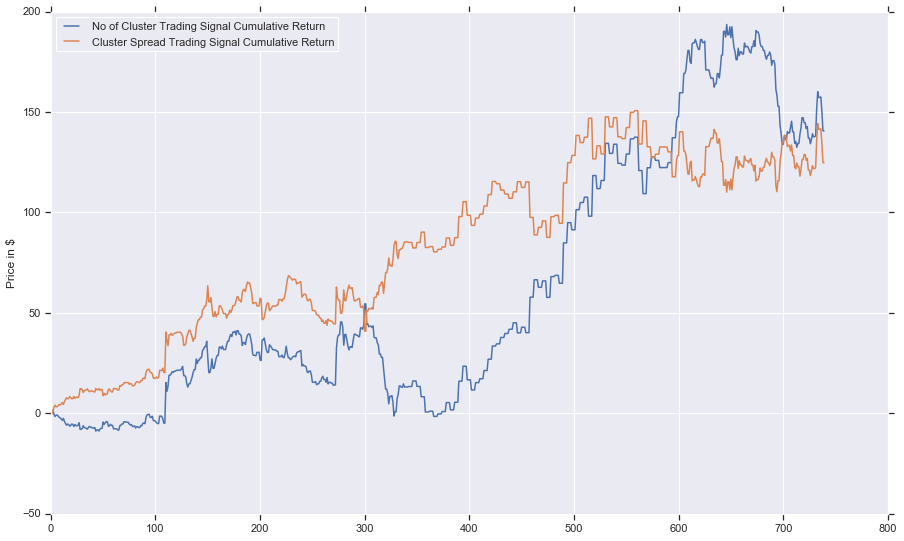

In [84]:
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(ready.index, ready['NoC CumSum'], label='No of Cluster Trading Signal Cumulative Return')
ax.plot(ready.index, ready['CS CumSum'], label='Cluster Spread Trading Signal Cumulative Return')
#ax.plot(ready.index, ready['Close'], label='Close Price')

ax.legend(loc='best')
ax.set_ylabel('Price in $')

In [117]:
# threshold = [0.1,.2,.3,.4,.5,.6,.7,.8]

# fig, ax = plt.subplots(figsize=(15,9))

# for x in threshold:    
#     ready['NoC Signal'] =  np.where(ready['no_clusters_norm']<threshold, 1, -1)
#     ready['NoC Returns'] = ready['returns'] * ready['NoC Signal']
#     ready['NoC CumSum'] = ready['NoC Returns'].cumsum()

#     ready['CS Signal'] =  np.where(ready['cluster_spread_norm']<threshold, 1, -1)
#     ready['CS Returns'] = ready['returns'] * ready['CS Signal']
#     ready['CS CumSum'] = ready['CS Returns'].cumsum()
    
#     ax.plot(ready.index, ready['NoC CumSum'], label='No of Cluster Trading Signal Cumulative Return' + str(threshold))
#     ax.plot(ready.index, ready['CS CumSum'], label='Cluster Spread Trading Signal Cumulative Return' + str(threshold))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

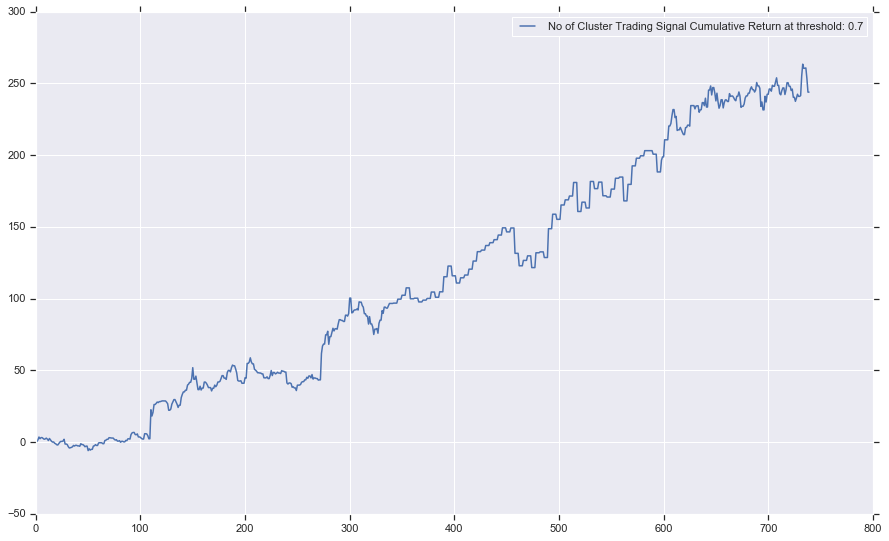

In [122]:
fig, ax = plt.subplots(figsize=(15,9))

ready['NoC Signal'] =  np.where(ready['no_clusters_norm']<0.7, 1, -1)
ready['NoC Returns'] = ready['returns'] * ready['NoC Signal']
ready['NoC CumSum'] = ready['NoC Returns'].cumsum()
ax.plot(ready.index, ready['NoC CumSum'], label='No of Cluster Trading Signal Cumulative Return at threshold: ' + str(0.7))
ax.legend(loc='best')

In [96]:
ready['no_clusters_norm'].count()

740

In [97]:
ready['NoC Signal'].count()

740

In [101]:
ready

,date,Close,no_clusters_norm,cluster_spread_norm,returns,NoC Signal,NoC Returns,NoC CumSum,Holding Returns,CS Signal,CS Returns,CS CumSum
0,2016-07-05,47.35,0.6,0.365519,NaN,-1,NaN,NaN,NaN,1,NaN,NaN
1,2016-07-06,47.65,0.2,0.793304,0.30,1,0.30,0.30,0.30,-1,-0.30,-0.30
2,2016-07-07,48.89,0.4,0.485491,1.24,1,1.24,1.54,1.54,1,1.24,0.94
3,2016-07-08,50.85,0.5,0.375795,1.96,-1,-1.96,-0.42,3.50,1,1.96,2.90
4,2016-07-11,52.02,0.8,0.301620,1.17,-1,-1.17,-1.59,4.67,1,1.17,4.07
5,2016-07-12,52.80,0.3,0.700033,0.78,1,0.78,-0.81,5.45,-1,-0.78,3.29
6,2016-07-13,52.78,0.4,0.481656,-0.02,1,-0.02,-0.83,5.43,1,-0.02,3.27
7,2016-07-14,53.32,0.9,0.255050,0.54,-1,-0.54,-1.37,5.97,1,0.54,3.81
8,2016-07-15,52.70,0.3,0.693728,-0.62,1,-0.62,-1.99,5.35,-1,0.62,4.43
9,2016-07-18,52.97,0.5,0.508132,0.27,-1,-0.27,-2.26,5.62,-1,-0.27,4.16
